# Liquid neural networks for wind power forecasting

In [1]:
import pandas as pd
import xarray as xr
import numpy as np

import random
import os

# import comp_utils

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import pickle as pkl

## additional lib.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm

from sam import SAM
# import GSAM class and scheduler
from gsam import GSAM, LinearScheduler

# from ncps.wirings import AutoNCP 
from ncps.torch import LTC

* 통일 data 전처리 code

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)



def read_weahter_nc_to_df(file_name, type="wind"):
    
    if type == "wind":
        ### DWD : Hornsea 1 (풍력 발전소) 관련 날씨 예보
        df = xr.open_dataset(file_name)
        
        # 6개의 feature 모두 활용하기 위함
        df = df[['RelativeHumidity', 'Temperature', 'WindDirection', 
                 'WindDirection:100', 'WindSpeed', 'WindSpeed:100']].mean(dim=["latitude", "longitude"]).to_dataframe().reset_index()
        
        df["ref_datetime"] = df["ref_datetime"].dt.tz_localize("UTC")
        df["valid_datetime"] = df["ref_datetime"] + pd.TimedeltaIndex(df["valid_datetime"], unit="hours")
        df.rename(columns={"Temperature":"Temperature_wind"}, inplace=True)

        return df
    
    if type == "solar":
        ### DWD : PES 10 (태양광 발전소) 관련 날씨 예보
        df = xr.open_dataset(file_name)
        
        # 3개의 feature 모두 활용하기 위함
        df = df[['CloudCover', 'SolarDownwardRadiation', 'Temperature']].mean(dim="point").to_dataframe().reset_index()
        
        df["ref_datetime"] = df["ref_datetime"].dt.tz_localize("UTC")
        df["valid_datetime"] = df["ref_datetime"] + pd.TimedeltaIndex(df["valid_datetime"],unit="hours")
        df.rename(columns={"Temperature":"Temperature_solar"}, inplace=True)
        
        return df

def read_weahter_nc_to_df2(file_name, type="wind"):
    
    if type == "wind":
        ### DWD : Hornsea 1 (풍력 발전소) 관련 날씨 예보
        df = xr.open_dataset(file_name)
        
        # 6개의 feature 모두 활용하기 위함
        df = df[['RelativeHumidity', 'Temperature', 'WindDirection', 
                 'WindDirection:100', 'WindSpeed', 'WindSpeed:100']].mean(dim=["latitude", "longitude"]).to_dataframe().reset_index()
        
        df["reference_time"] = df["reference_time"].dt.tz_localize("UTC")
        df["valid_time"] = df["reference_time"] + pd.TimedeltaIndex(df["valid_time"], unit="hours")
        df.rename(columns={"Temperature":"Temperature_wind"}, inplace=True)

        return df
    
    if type == "solar":
        ### DWD : PES 10 (태양광 발전소) 관련 날씨 예보
        df = xr.open_dataset(file_name)
        
        # 3개의 feature 모두 활용하기 위함
        df = df[['CloudCover', 'SolarDownwardRadiation', 'Temperature']].mean(dim="point").to_dataframe().reset_index()
        
        df["reference_time"] = df["reference_time"].dt.tz_localize("UTC")
        df["valid_time"] = df["reference_time"] + pd.TimedeltaIndex(df["valid_time"],unit="hours")
        df.rename(columns={"Temperature":"Temperature_solar"}, inplace=True)
    
        return df


def read_energy_nc_to_df(file_name):
    
    ### DWD : Hornsea 1 (풍력 발전소) 관련 날씨 예보
    energy_data = pd.read_csv(file_name)
    energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])
    energy_data["Wind_MWh_credit"] = 0.5*energy_data["Wind_MW"] - energy_data["boa_MWh"]
    energy_data["Solar_MWh_credit"] = 0.5*energy_data["Solar_MW"]
    energy_data.head()
        
    return energy_data


def merge_weather_and_energy(df_wind, df_solar, df_energy):
# def merge_weather_and_energy(df_wind, df_energy):
    
    ## Merge Energy and Weather Data
    modelling_table = df_wind.merge(df_solar, how="outer", on=["ref_datetime", "valid_datetime"])
    # modelling_table = df_wind.set_index("valid_datetime").groupby("ref_datetime").resample("30T").interpolate("linear")
    modelling_table = modelling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30T").interpolate("linear")
    modelling_table = modelling_table.drop(columns="ref_datetime", axis=1).reset_index()
    
    modelling_table = modelling_table.merge(df_energy, how="inner", 
                                            left_on="valid_datetime", 
                                            right_on="dtm")
    
    modelling_table = modelling_table[modelling_table["valid_datetime"] - modelling_table["ref_datetime"] < np.timedelta64(50, "h")]

    return modelling_table


def data_preprocess(modelling_table):
    # total_range = pd.date_range(start="2020-09-20", end="2023-10-27").strftime("%Y-%m-%d").to_list()
    total_range = pd.date_range(start="2020-09-20", end="2024-01-01").strftime("%Y-%m-%d").to_list()

    for i in range(len(total_range)):
        total_range[i] += " 00:00:00"

    re_modelling_table = pd.DataFrame()
    for i in range(len(total_range)):
        sliced_proper_df = modelling_table[modelling_table['ref_datetime'] == total_range[i]].iloc[:48,:]
        if (sliced_proper_df.shape[0] < 48) or (sliced_proper_df["valid_datetime"].iloc[0].day != sliced_proper_df["valid_datetime"].iloc[-1].day):
            # print(total_range[i]) # missing dates 출력.
            reconfig_date = total_range[i-1][:10] + " 18:00:00"
            reconfig_modelling_table = modelling_table[modelling_table['ref_datetime'] == reconfig_date].iloc[12:12+48,:]
            
            if (reconfig_modelling_table.shape[0] < 48) or (reconfig_modelling_table["valid_datetime"].iloc[0].day != reconfig_modelling_table["valid_datetime"].iloc[-1].day):
                reconfig_date = total_range[i-1][:10] + " 12:00:00" # set again to the previous forecast initial time.
                reconfig_modelling_table = modelling_table[modelling_table['ref_datetime'] == reconfig_date].iloc[12+12:12+12+48,:]
                
                if (reconfig_modelling_table.shape[0] < 48) or (reconfig_modelling_table["valid_datetime"].iloc[0].day != reconfig_modelling_table["valid_datetime"].iloc[-1].day):
                    # print(reconfig_date)
                    reconfig_date = total_range[i-1][:10] + " 06:00:00" # set again to the previous forecast initial time.
                    reconfig_modelling_table = modelling_table[modelling_table['ref_datetime'] == reconfig_date].iloc[12+12+12:12+12+12+48,:]
                    
                    if (reconfig_modelling_table.shape[0] < 48) or (reconfig_modelling_table["valid_datetime"].iloc[0].day != reconfig_modelling_table["valid_datetime"].iloc[-1].day):
                        reconfig_date = total_range[i-1][:10] + " 00:00:00" # set again to the previous forecast initial time.
                        reconfig_modelling_table = modelling_table[modelling_table['ref_datetime'] == reconfig_date].iloc[48:48+48,:]

                        if (reconfig_modelling_table.shape[0] < 48) or (reconfig_modelling_table["valid_datetime"].iloc[0].day != reconfig_modelling_table["valid_datetime"].iloc[-1].day):
                            print(total_range[i]) # missing dates 출력. <= 연쇄적으로 missing이어서 구할 수 없는 구간..
                            reconfig_modelling_table = None

            re_modelling_table = pd.concat([re_modelling_table, reconfig_modelling_table], axis=0)
        else:
            re_modelling_table = pd.concat([re_modelling_table, sliced_proper_df], axis=0)

    return re_modelling_table

In [3]:
# DWD 모델 사용
df_wind_ = read_weahter_nc_to_df(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\dwd_icon_eu_hornsea_1_20200920_20231027.nc", type="wind")
df_solar_ = read_weahter_nc_to_df(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\dwd_icon_eu_pes10_20200920_20231027.nc", type="solar")

df_wind_ = df_wind_[df_wind_['ref_datetime'] < '2023-10-27']
df_solar_ = df_solar_[df_solar_['ref_datetime'] < '2023-10-27']

df_wind__ = read_weahter_nc_to_df2(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\dwd_icon_eu_hornsea_1_20231027_20240108.nc", type="wind")
df_solar__ = read_weahter_nc_to_df2(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\dwd_icon_eu_pes10_20231027_20240108.nc", type="solar")

df_wind__ = df_wind__[df_wind__['valid_time'] < '2024-01-01']
df_solar__ = df_solar__[df_solar__['valid_time'] < '2024-01-01']

energy_data = read_energy_nc_to_df(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\Energy_Data_20200920_20240118.csv")
energy_data = energy_data[energy_data['dtm'] < '2024-01-01']

df_wind__.columns = df_wind_.columns
df_solar__.columns = df_solar_.columns

df_wind = pd.concat([df_wind_,df_wind__], axis=0)
df_solar = pd.concat([df_solar_,df_solar__], axis=0)

# modeling_table 1차
modeling_table = merge_weather_and_energy(df_wind, df_solar, energy_data)
# modeling_table = merge_weather_and_energy(df_wind, energy_data)

# modeling_table = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\data_for_wind_forecast_20200920_20240118.csv", index_col=0)
# modeling_table = modeling_table.iloc[:-912,:]

# additional output nan remove!!
modeling_table = modeling_table[~(modeling_table["Wind_MWh_credit"].isna())]

# re_modeling_table input/target 관계에 대한 noise 제거
modeling_table = modeling_table[~((modeling_table["WindSpeed:100"] >= 20) & (modeling_table["Wind_MWh_credit"] <= 270))] # threshold windspeed100 (20, 200)


modeling_columns = modeling_table.columns
df_SLP = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\Wind_SLP.csv")
df_SLP["Valid Time"] = pd.to_datetime(df_SLP["Valid Time"]).dt.tz_localize("UTC")
df_SLP.rename(columns={"Sea Level Pressure":"pressure"}, inplace=True)
## Merge Energy and Weather Data

temp_modeling_table = modeling_table.merge(df_SLP, how="outer", 
                                           left_on="valid_datetime",
                                           right_on="Valid Time")

temp_modeling_table['pressure'] = temp_modeling_table['pressure'].interpolate()
temp_modeling_table = temp_modeling_table[list(modeling_columns) + ["pressure"]]


# re_modeling_table
re_modelling_table = data_preprocess(temp_modeling_table)
# re_modelling_table = modeling_table

## additional noise removal!!
re_modelling_table = re_modelling_table[~((re_modelling_table["WindSpeed:100"] >= 7.5) & (re_modelling_table["Wind_MWh_credit"] <= 45))]

re_modelling_table = re_modelling_table[~((re_modelling_table["valid_datetime"] >= '2023-04-24') & (re_modelling_table["valid_datetime"] <= '2023-04-25'))]


#################### 선택 필요 ####################  
# re_modelling_table.interpolate('linear', inplace=True)
# re_modelling_table = re_modelling_table.dropna()
################################################### 

# re_modeling_table input/target 관계에 대한 noise 제거
# re_modelling_table = re_modelling_table[~((re_modelling_table["WindSpeed:100"] >= 20) & (re_modelling_table["Wind_MWh_credit"] <= 270))] # threshold windspeed100 (20, 200)

print(f"{len(re_modelling_table)}")

2021-11-15 00:00:00
2022-02-18 00:00:00
2022-11-25 00:00:00
2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00
2022-12-01 00:00:00
2022-12-02 00:00:00
2022-12-03 00:00:00
2022-12-04 00:00:00
2022-12-05 00:00:00
2022-12-06 00:00:00
2023-06-03 00:00:00
2023-06-04 00:00:00
2023-07-16 00:00:00
2023-08-16 00:00:00
2023-08-17 00:00:00
2023-09-16 00:00:00
2023-09-17 00:00:00
2023-12-31 00:00:00
2024-01-01 00:00:00
56219


In [4]:
# NCEP 모델 사용
df_wind_ = read_weahter_nc_to_df(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\ncep_gfs_hornsea_1_20200920_20231027.nc", type="wind")
df_solar_ = read_weahter_nc_to_df(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\ncep_gfs_pes10_20200920_20231027.nc", type="solar")

df_wind_ = df_wind_[df_wind_['ref_datetime'] < '2023-10-27']
df_solar_ = df_solar_[df_solar_['ref_datetime'] < '2023-10-27']

df_wind__ = read_weahter_nc_to_df2(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\ncep_gfs_hornsea_1_20231027_20240108.nc", type="wind")
df_solar__ = read_weahter_nc_to_df2(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\ncep_gfs_pes10_20231027_20240108.nc", type="solar")

df_wind__ = df_wind__[df_wind__['valid_time'] < '2024-01-01']
df_solar__ = df_solar__[df_solar__['valid_time'] < '2024-01-01']

energy_data = read_energy_nc_to_df(file_name=r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\Energy_Data_20200920_20240118.csv")
energy_data = energy_data[energy_data['dtm'] < '2024-01-01']

df_wind__.columns = df_wind_.columns
df_solar__.columns = df_solar_.columns

df_wind = pd.concat([df_wind_,df_wind__], axis=0)
df_solar = pd.concat([df_solar_,df_solar__], axis=0)

# modeling_table 1차
modeling_table_ncep = merge_weather_and_energy(df_wind, df_solar, energy_data)
# modeling_table = merge_weather_and_energy(df_wind, energy_data)

# modeling_table = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\data_for_wind_forecast_20200920_20240118.csv", index_col=0)
# modeling_table = modeling_table.iloc[:-912,:]

# additional output nan remove!!
modeling_table_ncep = modeling_table_ncep[~(modeling_table_ncep["Wind_MWh_credit"].isna())]

# re_modeling_table input/target 관계에 대한 noise 제거
modeling_table_ncep = modeling_table_ncep[~((modeling_table_ncep["WindSpeed:100"] >= 20) & (modeling_table_ncep["Wind_MWh_credit"] <= 270))] # threshold windspeed100 (20, 200)


modeling_columns = modeling_table_ncep.columns
df_SLP = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\Wind_SLP.csv")
df_SLP["Valid Time"] = pd.to_datetime(df_SLP["Valid Time"]).dt.tz_localize("UTC")
df_SLP.rename(columns={"Sea Level Pressure":"pressure"}, inplace=True)
## Merge Energy and Weather Data

temp_modeling_table = modeling_table_ncep.merge(df_SLP, how="outer", 
                                           left_on="valid_datetime",
                                           right_on="Valid Time")

temp_modeling_table['pressure'] = temp_modeling_table['pressure'].interpolate()
temp_modeling_table = temp_modeling_table[list(modeling_columns) + ["pressure"]]


# re_modeling_table
re_modelling_table_ncep = data_preprocess(temp_modeling_table)
# re_modelling_table = modeling_table

## additional noise removal!!
re_modelling_table_ncep = re_modelling_table_ncep[~((re_modelling_table_ncep["WindSpeed:100"] >= 7.5) & (re_modelling_table_ncep["Wind_MWh_credit"] <= 45))]

re_modelling_table_ncep = re_modelling_table_ncep[~((re_modelling_table_ncep["valid_datetime"] >= '2023-04-24') & (re_modelling_table_ncep["valid_datetime"] <= '2023-04-25'))]


#################### 선택 필요 ####################  
# re_modelling_table.interpolate('linear', inplace=True)
# re_modelling_table = re_modelling_table.dropna()
################################################### 

# re_modeling_table input/target 관계에 대한 noise 제거
# re_modelling_table = re_modelling_table[~((re_modelling_table["WindSpeed:100"] >= 20) & (re_modelling_table["Wind_MWh_credit"] <= 270))] # threshold windspeed100 (20, 200)

print(f"{len(re_modelling_table_ncep)}")

2021-11-15 00:00:00
2022-02-18 00:00:00
2023-06-03 00:00:00
2023-06-04 00:00:00
2023-08-16 00:00:00
2023-08-17 00:00:00
2023-09-16 00:00:00
2023-09-17 00:00:00
2023-12-31 00:00:00
2024-01-01 00:00:00
56685


In [5]:
# feature engineering for wind forecsting

import math

def air_density(pressure, temperature, relative_humidity):
    """
    Calculate air density in kg/m^3 given pressure in Pa, temperature in K, and relative humidity as a fraction.
    """
    # Calculate saturation vapor pressure
    e_s = 6.1078 * 10 ** ((7.5 * temperature) / (temperature + 237.3))
    # Calculate vapor pressure
    e = relative_humidity * e_s
    # Calculate dry air pressure
    p_dry = pressure - e
    # Calculate air density
    rho = (p_dry / (287.058 * temperature)) + ((e / (287.058 * temperature)) * (1 - 0.378 * (e / p_dry)))
    return rho

def calculate_absolute_humidity(wind_speed, wind_direction, temperature, pressure, humidity):
    # Calculate dew point temperature
    T = temperature
    RH = 0.5  # Assuming relative humidity of 50%
    a = 17.27
    b = 237.7
    alpha = ((a * T) / (b + T)) + math.log(RH)
    dew_point = (b * alpha) / (a - alpha)

    # Calculate saturation vapor pressure
    e_s = 6.112 * math.exp((17.67 * dew_point) / (dew_point + 243.5))

    # Calculate actual vapor pressure
    e_a = e_s * (humidity / 100)

    # Calculate absolute humidity
    R_d = 287.058  # Specific gas constant for dry air
    R_v = 461.495  # Specific gas constant for water vapor
    T_K = temperature + 273.15  # Temperature in Kelvin
    e_a_Pa = e_a * 100  # Convert vapor pressure to Pascals
    rho_d = (pressure * 100) / (R_d * T_K)  # Density of dry air in kg/m^3
    rho_v = (e_a_Pa / (R_v * T_K))  # Density of water vapor in kg/m^3
    absolute_humidity = (rho_v / (rho_d + rho_v)) * 1000  # Absolute humidity in g/m^3

    return absolute_humidity


def calculate_air_pressure(pressure, temperature, relative_humidity):
    R_d = 287.058  # Specific gas constant for dry air
    R_v = 461.495  # Specific gas constant for water vapor
    T_K = temperature + 273.15  # Temperature in Kelvin

    # Calculate saturation vapor pressure
    T_C = temperature  # Temperature in Celsius
    e_s = 6.112 * math.exp((17.67 * T_C) / (T_C + 243.5))

    # Calculate actual vapor pressure
    e = e_s * (relative_humidity / 100)

    # Calculate air density
    rho_d = (pressure * 100) / (R_d * T_K)  # Density of dry air in kg/m^3
    rho_v = (e * 100) / (R_v * T_K)  # Density of water vapor in kg/m^3
    rho = rho_d + rho_v  # Total density of air in kg/m^3

    # Calculate air pressure
    air_pressure = rho * R_d * T_K / 100  # Air pressure in hPa

    return air_pressure

# re_modelling_table['component_x'] = re_modelling_table['WindSpeed']*np.cos(re_modelling_table['WindSpeed']*np.pi/180)
# re_modelling_table['component_y'] = re_modelling_table['WindDirection']*np.sin(re_modelling_table['WindDirection']*np.pi/180)
# re_modelling_table['component_x:100'] = re_modelling_table['WindSpeed:100']*np.cos(re_modelling_table['WindSpeed:100']*np.pi/180)
# re_modelling_table['component_y:100'] = re_modelling_table['WindDirection:100']*np.sin(re_modelling_table['WindDirection:100']*np.pi/180)

re_modelling_table['air_density'] = re_modelling_table.apply(lambda x : air_density(x['pressure'], x['Temperature_wind'], x['RelativeHumidity']), axis=1)
re_modelling_table['absolute_humidity'] = re_modelling_table.apply(lambda x : calculate_absolute_humidity(x['WindSpeed:100'], x['WindDirection:100'], x['Temperature_wind'], x['pressure'], x['RelativeHumidity']), axis=1)
re_modelling_table['air_pressure'] = re_modelling_table.apply(lambda x : calculate_air_pressure(x['pressure'], x['Temperature_wind'], x['RelativeHumidity']), axis=1)

re_modelling_table_ncep['air_density'] = re_modelling_table_ncep.apply(lambda x : air_density(x['pressure'], x['Temperature_wind'], x['RelativeHumidity']), axis=1)
re_modelling_table_ncep['absolute_humidity'] = re_modelling_table_ncep.apply(lambda x : calculate_absolute_humidity(x['WindSpeed:100'], x['WindDirection:100'], x['Temperature_wind'], x['pressure'], x['RelativeHumidity']), axis=1)
re_modelling_table_ncep['air_pressure'] = re_modelling_table_ncep.apply(lambda x : calculate_air_pressure(x['pressure'], x['Temperature_wind'], x['RelativeHumidity']), axis=1)

* 예보모델 평균

In [6]:
# 두 데이터프레임을 연결하여 하나의 데이터프레임으로 합침
merged_df = pd.concat([re_modelling_table, re_modelling_table_ncep], axis=0)

# 인덱스를 기준으로 그룹화하여 평균을 구함
modeling_table = merged_df.reset_index().groupby(['ref_datetime', 'valid_datetime']).mean().reset_index()

## 대회 예측 시간대에 맞춰서 time interval 조정!
re_modelling_table_temp = modeling_table.iloc[44:,:].reset_index(drop=True) ## 46 // 44 (UTC // (EU) London)
temp_df = pd.DataFrame(columns=re_modelling_table_temp.columns)
for i in range(int(re_modelling_table_temp.shape[0]/48)):
    temp_ = re_modelling_table_temp.iloc[48*i:48*(i+1),:]
    if temp_.shape[0] == 48:
        temp_df = pd.concat([temp_df, temp_], axis=0)

modeling_table = temp_df

* 예보모델 concat

In [6]:
# re_modelling_table_temp = re_modelling_table.iloc[46:,:].reset_index(drop=True)
# temp_df_dwd = pd.DataFrame(columns=re_modelling_table_temp.columns)
# for i in range(int(re_modelling_table_temp.shape[0]/48)):
#     temp_ = re_modelling_table_temp.iloc[48*i:48*(i+1),:]
#     if temp_.shape[0] == 48:
#         temp_df_dwd = pd.concat([temp_df_dwd, temp_], axis=0)


# re_modelling_table_temp = re_modelling_table_ncep.iloc[46:,:].reset_index(drop=True)
# temp_df_ncep = pd.DataFrame(columns=re_modelling_table_temp.columns)
# for i in range(int(re_modelling_table_temp.shape[0]/48)):
#     temp_ = re_modelling_table_temp.iloc[48*i:48*(i+1),:]
#     if temp_.shape[0] == 48:
#         temp_df_ncep = pd.concat([temp_df_ncep, temp_], axis=0)

# temp_df_concat = temp_df_dwd.merge(temp_df_ncep, how="inner", 
#                                     left_on="valid_datetime", 
#                                     right_on="valid_datetime")

# temp_df_concat = temp_df_concat.dropna()

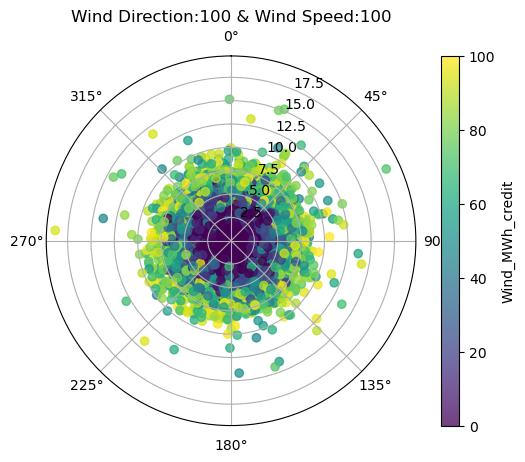

In [7]:
from matplotlib.colorbar import ColorbarBase
from obspy.imaging.cm import get_cmap
from matplotlib.colors import Normalize

outlier_modeling_table = re_modelling_table[re_modelling_table['Wind_MWh_credit'] <= 100]

cmap = get_cmap('YlGnBu')

# Compute areas and colors

radiance = outlier_modeling_table['WindSpeed:100']
theta = outlier_modeling_table['WindDirection:100']
power = outlier_modeling_table['Wind_MWh_credit']

fig = plt.figure()

ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)

ax.set_title(f'Wind Direction:100 & Wind Speed:100')

c = ax.scatter(theta, radiance, c=power, cmap='viridis', alpha=0.75)

# Colorbar 추가
cbar = fig.colorbar(c)
cbar.set_label('Wind_MWh_credit')

plt.show()

In [7]:
# Final forecasting model input/output data structure.
# re_modelling_table.loc[:,['valid_datetime', 'WindSpeed', 'SolarDownwardRadiation', 'total_generation_MWh']]
# re_modelling_table.loc[:,['valid_datetime', 'WindSpeed', 'WindDirection', 'RelativeHumidity', 'Temperature', 'Wind_MWh_credit']]
# re_modelling_table.loc[:,['valid_datetime', 'WindSpeed:100', 'WindDirection:100', 'RelativeHumidity', 'Temperature_wind', 'pressure', 'air_density', 'absolute_humidity', 'air_pressure', 'Wind_MWh_credit']]

# final_dataset = re_modelling_table.loc[:,['WindSpeed', 'SolarDownwardRadiation', 'total_generation_MWh']].values
# final_dataset = re_modelling_table.loc[:,['WindSpeed:100', 'WindDirection:100', 'RelativeHumidity', 'Temperature_wind','Wind_MWh_credit']].values
# final_dataset = re_modelling_table.loc[:,['WindSpeed:100', 'WindSpeed', 'WindDirection:100', 'WindDirection', 'RelativeHumidity', 'Temperature_wind', 'pressure', 'air_density', 'absolute_humidity', 'air_pressure', 'Wind_MWh_credit']].values
# final_dataset = re_modelling_table.loc[:,['WindSpeed:100', 'WindSpeed', 'WindDirection:100', 'WindDirection', 'RelativeHumidity', 'pressure', 'air_density', 'absolute_humidity', 'Wind_MWh_credit']].values

# final_dataset = re_modelling_table.loc[:,['WindSpeed:100', 'WindSpeed', 'WindDirection:100', 'WindDirection', 'RelativeHumidity', 'pressure', 'air_density', 'absolute_humidity', 'Wind_MWh_credit']].values

## 평균화
final_dataset = modeling_table.loc[:,['WindSpeed:100', 'WindSpeed', 'WindDirection:100', 'WindDirection', 'RelativeHumidity', 'pressure', 'air_density', 'absolute_humidity', 'Wind_MWh_credit']].values
## concat
# final_dataset = temp_df_concat.loc[:,['WindSpeed:100_x', 'WindSpeed:100_y', 'WindSpeed_x', 'WindSpeed_y', 'WindDirection:100_x', 'WindDirection:100_y', 
#                                       'WindDirection_x', 'WindDirection_y', 'RelativeHumidity_x', 'RelativeHumidity_y', 'pressure_x', 'pressure_y', 'air_density_x', 'air_density_y',
#                                       'absolute_humidity_x', 'absolute_humidity_y', 'Wind_MWh_credit_x']].values

# final_dataset = re_modelling_table.loc[:,['WindDirection', 'WindDirection:100', 'WindSpeed', 'WindSpeed:100', 'component_x', 'component_x:100', 'component_y', 'component_y:100', 'absolute_humidity', 'air_pressure', 'Wind_MWh_credit']].values


In [8]:
final_dataset.shape

(57024, 9)

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler

# input features
# windspeed_100 = final_dataset[:,0].reshape(-1, 48)
# winddirection_100 = final_dataset[:,1].reshape(-1, 48)
# humid = final_dataset[:,2].reshape(-1, 48)
# temp = final_dataset[:,3].reshape(-1, 48)

windspeed_100 = final_dataset[:,0].reshape(-1, 48)
windspeed = final_dataset[:,1].reshape(-1, 48)
winddirection_100 = final_dataset[:,2].reshape(-1, 48)
winddirection = final_dataset[:,3].reshape(-1, 48)
humid = final_dataset[:,4].reshape(-1, 48)
# temp = final_dataset[:,5].reshape(-1, 48)
pressure = final_dataset[:,5].reshape(-1, 48)
air_dens = final_dataset[:,6].reshape(-1, 48)
abs_humid = final_dataset[:,7].reshape(-1, 48)
# air_pressure = final_dataset[:,9].reshape(-1, 48)

# winddirection = final_dataset[:,0].reshape(-1, 48)
# winddirection_100 = final_dataset[:,1].reshape(-1, 48)
# windspeed = final_dataset[:,2].reshape(-1, 48)
# windspeed_100 = final_dataset[:,3].reshape(-1, 48)
# comp_x = final_dataset[:,4].reshape(-1, 48)
# comp_x_100 = final_dataset[:,5].reshape(-1, 48)
# comp_y = final_dataset[:,6].reshape(-1, 48)
# comp_y_100 = final_dataset[:,7].reshape(-1, 48)
# abs_humid = final_dataset[:,8].reshape(-1, 48)
# air_press = final_dataset[:,9].reshape(-1, 48)


# Normalization of each input feature
# windspeed_,_,_ = norm(windspeed)
# solar_downward_,_,_ = norm(solar_downward)
# # winddirection_,_,_ = norm(winddirection)
# humid_,_,_ = norm(humid)
# cloud_,_,_ = norm(cloud)
# temp_,_,_ = norm(temp)

# input = np.concatenate([windspeed, winddirection, humid, temp], axis=1)
# input = np.concatenate([windspeed_100, winddirection_100, humid, temp], axis=1)
input = np.concatenate([windspeed_100, windspeed, winddirection_100, winddirection, humid, pressure, air_dens, abs_humid], axis=1)
# input = np.concatenate([winddirection, winddirection_100, windspeed, windspeed_100, comp_x, comp_x_100, comp_y, comp_y_100, abs_humid, air_press], axis=1)

# input = np.concatenate([windspeed_, solar_downward_, humid_, cloud_, temp_], axis=1)

# output
# target = final_dataset[:,4].reshape(-1,48)
# target = final_dataset[:,10].reshape(-1,48)
target = final_dataset[:,8].reshape(-1,48)


# split the training/validation/test set
train_len = int(len(input)*0.8)
val_len = int(len(input)*0.1)

train_input = input[:train_len,:]
train_output = target[:train_len,:]

val_input = input[train_len:train_len+val_len,:]
val_output = target[train_len:train_len+val_len,:]

test_input = input[train_len+val_len:,:]
test_output = target[train_len+val_len:,:]

# Normalization of each dataset
scalerX = StandardScaler() # RobustScaler(quantile_range=(10.0, 90.0)) # StandardScaler()
scalerX = scalerX.fit(train_input)
# scale
train_input = scalerX.transform(train_input)
val_input = scalerX.transform(val_input)
test_input = scalerX.transform(test_input)

scalerY = MaxAbsScaler() # QuantileTransformer(n_quantiles=30, random_state=0, output_distribution="normal") # StandardScaler()\
scalerY = scalerY.fit(train_output)
# scale
train_output = scalerY.transform(train_output)
val_output = scalerY.transform(val_output)
test_output = scalerY.transform(test_output)

# train_input_, _, _ = norm(train_input)
train_input_ = train_input
# train_output_, train_max, train_min = norm(train_output)
train_output_ = train_output


# val_input_, _, _ = norm(val_input)
val_input_ = val_input
# val_output_, val_max, val_min = norm(val_output)
val_output_ = val_output

# test_input_, _, _ = norm(test_input)
test_input_ = test_input
# test_output_, test_max, test_min = norm(test_output)
test_output_ = test_output


## Test phase: 거의 실제 모델 성능 check!

In [9]:
dwd_test_weather = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\dwd_icon_eu_weather_forecast_for_wind_solar_20240518_0.csv", index_col=0)
# dwd_test_weather = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\data\data_for_wind_forecast_20200920_20240118.csv", index_col=0)
# dwd_test_weather = dwd_test_weather.iloc[-912:,:]

# dwd_test_weather = dwd_test_weather[(dwd_test_weather['valid_datetime'] >= '2024-04-11 23:00:00') & (dwd_test_weather['valid_datetime'] < '2024-04-12 23:00:00')] # UTC
dwd_test_weather = dwd_test_weather[(dwd_test_weather['valid_datetime'] >= '2024-05-18 22:00:00') & (dwd_test_weather['valid_datetime'] < '2024-05-19 22:00:00')] # london time
dwd_test_weather['valid_datetime'] = pd.DatetimeIndex(dwd_test_weather['valid_datetime'])

# dwd_test_weather['PressureReducedMSL_x'] = dwd_test_weather['pressure']/100

dwd_test_weather['PressureReducedMSL_x'] = dwd_test_weather['PressureReducedMSL_x']/100
# dwd_test_weather['PressureReducedMSL_x'] = dwd_test_weather['PressureReducedMSL']/100

# dwd_test_weather['air_density'] = dwd_test_weather.apply(lambda x : air_density(x['PressureReducedMSL_x'], x['Temperature_wind'], x['RelativeHumidity']), axis=1)
# dwd_test_weather['absolute_humidity'] = dwd_test_weather.apply(lambda x : calculate_absolute_humidity(x['WindSpeed:100'], x['WindDirection:100'], x['Temperature_wind'], x['PressureReducedMSL_x'], x['RelativeHumidity']), axis=1)

dwd_test_weather['air_density'] = dwd_test_weather.apply(lambda x : air_density(x['PressureReducedMSL_x'], x['Temperature_x'], x['RelativeHumidity']), axis=1)
dwd_test_weather['absolute_humidity'] = dwd_test_weather.apply(lambda x : calculate_absolute_humidity(x['WindSpeed:100'], x['WindDirection:100'], x['Temperature_x'], x['PressureReducedMSL_x'], x['RelativeHumidity']), axis=1)


# test_modeling_columns = dwd_test_weather.columns

# df_SLP = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\Wind_Pressure_20240109.csv")
# df_SLP["Valid Time"] = pd.to_datetime(df_SLP["Valid Time"]).dt.tz_localize("UTC")
# df_SLP.rename(columns={"Sea Level Pressure":"pressure"}, inplace=True)
# ## Merge Energy and Weather Data

# test_modeling_table = dwd_test_weather.merge(df_SLP, how="outer", 
#                                                 left_on="valid_datetime", 
#                                                 right_on="Valid Time")

# test_modeling_table['pressure'] = test_modeling_table['pressure'].interpolate()
# test_modeling_table = test_modeling_table[list(test_modeling_columns) + ["pressure"]]
# test_modeling_table = test_modeling_table[(test_modeling_table['valid_datetime'] >= '2024-01-18 23:00:00') & (test_modeling_table['valid_datetime'] < '2024-01-19 23:00:00')]
# test_modeling_table = test_modeling_table.dropna()

# test_modeling_table['air_density'] = test_modeling_table.apply(lambda x : air_density(x['pressure'], x['Temperature_x'], x['RelativeHumidity']), axis=1)
# test_modeling_table['absolute_humidity'] = test_modeling_table.apply(lambda x : calculate_absolute_humidity(x['WindSpeed:100'], x['WindDirection:100'], x['Temperature_x'], x['pressure'], x['RelativeHumidity']), axis=1)




# weather_input = dwd_test_weather.loc[:,['WindSpeed:100', 'WindDirection:100', 'Temperature_x', 'RelativeHumidity']].values
weather_input = dwd_test_weather.loc[:,['WindSpeed:100', 'WindSpeed', 'WindDirection:100', 'WindDirection', 'RelativeHumidity', 'PressureReducedMSL_x', 'air_density', 'absolute_humidity']].values
# weather_input = test_modeling_table.loc[:,['WindSpeed:100', 'WindSpeed', 'WindDirection:100', 'WindDirection', 'RelativeHumidity', 'pressure', 'air_density', 'absolute_humidity']].values

# wind_test = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\wind_mv_2023-12-27.csv",index_col=0)

# target_output = (0.5*wind_test["generation_mw"] - wind_test["boa"]).values.reshape(-1,1).T



In [10]:
ncep_test_weather = pd.read_csv(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\ncep_gfs_weather_forecast_for_wind_solar_20240518_0.csv", index_col=0)

# ncep_test_weather = ncep_test_weather[(ncep_test_weather['valid_datetime'] >= '2024-04-11 23:00:00') & (ncep_test_weather['valid_datetime'] < '2024-04-12 23:00:00')] # UTC
ncep_test_weather = ncep_test_weather[(ncep_test_weather['valid_datetime'] >= '2024-05-18 22:00:00') & (ncep_test_weather['valid_datetime'] < '2024-05-19 22:00:00')] # London time
ncep_test_weather['valid_datetime'] = pd.DatetimeIndex(ncep_test_weather['valid_datetime'])

ncep_test_weather['PressureReducedMSL_x'] = ncep_test_weather['PressureReducedMSL_x']/100

ncep_test_weather['air_density'] = ncep_test_weather.apply(lambda x : air_density(x['PressureReducedMSL_x'], x['Temperature_x'], x['RelativeHumidity']), axis=1)
ncep_test_weather['absolute_humidity'] = ncep_test_weather.apply(lambda x : calculate_absolute_humidity(x['WindSpeed:100'], x['WindDirection:100'], x['Temperature_x'], x['PressureReducedMSL_x'], x['RelativeHumidity']), axis=1)

weather_input_ncep = ncep_test_weather.loc[:,['WindSpeed:100', 'WindSpeed', 'WindDirection:100', 'WindDirection', 'RelativeHumidity', 'PressureReducedMSL_x', 'air_density', 'absolute_humidity']].values

* 평균화

In [11]:
# 두 데이터프레임을 연결하여 하나의 데이터프레임으로 합침
test_weather_merged_df = pd.concat([dwd_test_weather, ncep_test_weather], axis=0)

test_weather_merged_df = test_weather_merged_df.reset_index().groupby(['ref_datetime', 'valid_datetime']).mean().reset_index()
weather_input = test_weather_merged_df.loc[:,['WindSpeed:100', 'WindSpeed', 'WindDirection:100', 'WindDirection', 'RelativeHumidity', 'PressureReducedMSL_x', 'air_density', 'absolute_humidity']].values

* Concat

In [25]:
# # 두 데이터프레임을 연결하여 하나의 데이터프레임으로 합침
# dwd_test_weather.columns = ['valid_datetime', 'ref_datetime', 'PressureReducedMSL_x', 'RelativeHumidity_x', 'Temperature_x', 'TotalPrecipitation_x', 'WindDirection_x', 'WindDirection:100_x', 
#                             'WindSpeed_x', 'WindSpeed:100_x', 'SolarDownwardRadiation_x', 'TotalPrecipitation_y_x', 'CloudCover_x', 'Temperature_y_x', 'PressureReducedMSL_y_x', 'air_density_x', 'absolute_humidity_x']
# ncep_test_weather.columns = ['valid_datetime', 'ref_datetime', 'PressureReducedMSL_y', 'RelativeHumidity_y', 'Temperature_y', 'TotalPrecipitation_y', 'WindDirection_y', 'WindDirection:100_y', 
#                             'WindSpeed_y', 'WindSpeed:100_y', 'SolarDownwardRadiation_y', 'TotalPrecipitation_y_y', 'CloudCover_y', 'Temperature_y_y', 'PressureReducedMSL_y_y', 'air_density_y', 'absolute_humidity_y']
# test_weather_merged_df = pd.concat([dwd_test_weather, ncep_test_weather], axis=1)

# weather_input = test_weather_merged_df.loc[:,['WindSpeed:100_x', 'WindSpeed:100_y', 'WindSpeed_x', 'WindSpeed_y', 'WindDirection:100_x', 'WindDirection:100_y', 
#                                               'WindDirection_x', 'WindDirection_y', 'RelativeHumidity_x', 'RelativeHumidity_y', 'PressureReducedMSL_x', 'PressureReducedMSL_y', 
#                                               'air_density_x', 'air_density_y', 'absolute_humidity_x', 'absolute_humidity_y']].values

In [23]:
weather_input = weather_input_ncep
weather_input.shape

(48, 8)

* 이전의 train, test 다 합치기

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler

# input features
windspeed_100 = final_dataset[:,0].reshape(-1, 48)
windspeed = final_dataset[:,1].reshape(-1, 48)
winddirection_100 = final_dataset[:,2].reshape(-1, 48)
winddirection = final_dataset[:,3].reshape(-1, 48)
rel_humid = final_dataset[:,4].reshape(-1, 48)
press = final_dataset[:,5].reshape(-1, 48)
air_dens = final_dataset[:,6].reshape(-1, 48)
abs_humid = final_dataset[:,7].reshape(-1, 48)

# windspeed_100_x = final_dataset[:,0].reshape(-1, 48)
# windspeed_100_y = final_dataset[:,1].reshape(-1, 48)
# windspeed_x = final_dataset[:,2].reshape(-1, 48)
# windspeed_y = final_dataset[:,3].reshape(-1, 48)
# winddirection_100_x = final_dataset[:,4].reshape(-1, 48)
# winddirection_100_y = final_dataset[:,5].reshape(-1, 48)
# winddirection_x = final_dataset[:,6].reshape(-1, 48)
# winddirection_y = final_dataset[:,7].reshape(-1, 48)
# rel_humid_x = final_dataset[:,8].reshape(-1, 48)
# rel_humid_y = final_dataset[:,9].reshape(-1, 48)
# press_x = final_dataset[:,10].reshape(-1, 48)
# press_y = final_dataset[:,11].reshape(-1, 48)
# air_dens_x = final_dataset[:,12].reshape(-1, 48)
# air_dens_y = final_dataset[:,13].reshape(-1, 48)
# abs_humid_x = final_dataset[:,14].reshape(-1, 48)
# abs_humid_y = final_dataset[:,15].reshape(-1, 48)


# input = np.concatenate([solar_downward, cloud, temp], axis=1)

input = np.concatenate([windspeed_100, windspeed, winddirection_100, winddirection, rel_humid, press, air_dens, abs_humid], axis=1)
# input = np.concatenate([windspeed_100_x, windspeed_100_y, windspeed_x, windspeed_y, winddirection_100_x, winddirection_100_y, winddirection_x, winddirection_y, 
#                         rel_humid_x, rel_humid_y, press_x, press_y, air_dens_x, air_dens_y, abs_humid_x, abs_humid_y], axis=1)

target = final_dataset[:,8].reshape(-1,48)
# target = final_dataset[:,16].reshape(-1,48)


# Normalization of each dataset
# scalerX = StandardScaler() # MaxAbsScaler() # RobustScaler(quantile_range=(10.0, 90.0))
scalerX = MaxAbsScaler() 

# scalerX = scalerX.fit(train_input)
scalerX = scalerX.fit(input)

# scale
# train_input = scalerX.transform(train_input)
# val_input = scalerX.transform(val_input)

train_input = scalerX.transform(input)

# scalerY = MaxAbsScaler() # QuantileTransformer(n_quantiles=30, random_state=0, output_distribution="normal") # QuantileTransformer(n_quantiles=30, random_state=0, output_distribution="normal") # MaxAbsScaler() # 
scalerY = QuantileTransformer(n_quantiles=30, random_state=0, output_distribution="normal")  

# scalerY = scalerY.fit(train_output)
scalerY = scalerY.fit(target)

# scale
# train_output = scalerY.transform(train_output)
# val_output = scalerY.transform(val_output)

train_output = scalerY.transform(target)

###############################################
# train_input_ = train_input
# train_output_ = train_output
# val_input_ = val_input
# val_output_ = val_output

train_input_ = train_input
train_output_ = train_output

* test input 처리

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler

# input features
windspeed_100_ = weather_input[:,0].reshape(-1, 48)
windspeed_ = weather_input[:,1].reshape(-1, 48)
winddirection_100_ = weather_input[:,2].reshape(-1, 48)
winddirection_ = weather_input[:,3].reshape(-1, 48)
rel_humid_ = weather_input[:,4].reshape(-1, 48)
press_ = weather_input[:,5].reshape(-1, 48)
air_dens_ = weather_input[:,6].reshape(-1, 48)
abs_humid_ = weather_input[:,7].reshape(-1, 48)

# windspeed_100_x = weather_input[:,0].reshape(-1, 48)
# windspeed_100_y = weather_input[:,1].reshape(-1, 48)
# windspeed_x = weather_input[:,2].reshape(-1, 48)
# windspeed_y = weather_input[:,3].reshape(-1, 48)
# winddirection_100_x = weather_input[:,4].reshape(-1, 48)
# winddirection_100_y = weather_input[:,5].reshape(-1, 48)
# winddirection_x = weather_input[:,6].reshape(-1, 48)
# winddirection_y = weather_input[:,7].reshape(-1, 48)
# rel_humid_x = weather_input[:,8].reshape(-1, 48)
# rel_humid_y = weather_input[:,9].reshape(-1, 48)
# press_x = weather_input[:,10].reshape(-1, 48)
# press_y = weather_input[:,11].reshape(-1, 48)
# air_dens_x = weather_input[:,12].reshape(-1, 48)
# air_dens_y = weather_input[:,13].reshape(-1, 48)
# abs_humid_x = weather_input[:,14].reshape(-1, 48)
# abs_humid_y = weather_input[:,15].reshape(-1, 48)

input_ = np.concatenate([windspeed_100_, windspeed_, winddirection_100_, winddirection_, rel_humid_, press_, air_dens_, abs_humid_], axis=1)
# input_ = np.concatenate([windspeed_100_x, windspeed_100_y, windspeed_x, windspeed_y, winddirection_100_x, 
#                          winddirection_100_y, winddirection_x, winddirection_y, rel_humid_x, rel_humid_y, press_x, press_y, air_dens_x, air_dens_y, abs_humid_x, abs_humid_y], axis=1)

# output
# test_target = target_output

# Normalization of each dataset
# scalerX = MaxAbsScaler() # RobustScaler(quantile_range=(10.0, 90.0))
# scalerX = scalerX.fit(train_input)
# scalerX = scalerX.fit(input)

input_ = scalerX.transform(input_)

In [14]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, IterableDataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.xdomain = x_tensor
        self.ydomain = y_tensor
        
    def __getitem__(self, index):
        return (self.xdomain[index], self.ydomain[index])
    
    def __len__(self):
        return len(self.xdomain)

In [15]:
# batch_size = 128 # 32: QLSTM, 128: QTransLSTM

# train_dataset = CustomDataset(torch.tensor(train_input_, dtype=torch.float), torch.tensor(train_output_, dtype=torch.float))
# val_dataset = CustomDataset(torch.tensor(val_input_, dtype=torch.float), torch.tensor(val_output_, dtype=torch.float))
# test_dataset = CustomDataset(torch.tensor(test_input_, dtype=torch.float), torch.tensor(test_output_, dtype=torch.float))


# train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
# val_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [15]:
## (Huber) Quantile loss 
def QuantileLoss(preds, target, quantiles):
  assert not target.requires_grad
  assert preds.size(0) == target.size(0)
  losses = []
  for i, q in enumerate(quantiles):
    # errors = target - preds[:, i]
    # errors = target - preds[:, i*48:(i+1)*48]
    errors = target - preds[:, i, :]

    # # # huber loss
    # zero_error = torch.zeros_like(errors)
    # sq = torch.maximum(-errors, torch.zeros_like(errors))
    # s1_q = torch.maximum(errors, torch.zeros_like(errors))    
    # h_loss = F.huber_loss(q*sq, zero_error, reduction='none', delta=1.0) + F.huber_loss((1-q)*s1_q, zero_error, reduction='none', delta=1.0)
    # losses.append(h_loss.unsqueeze(1))
    
    losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))

    # if i == 0:
    #   losses = torch.max((q-1)*errors, q*errors).unsqueeze(1)
    #   # losses = torch.max((q-1)*errors, q*errors).reshape(1)
    # else:
    #   losses = torch.cat((losses, torch.max((q-1)*errors, q*errors).unsqueeze(1)))
    #   # losses = torch.cat((losses, torch.max((q-1) * errors, q * errors).reshape(1)))
  
  # loss = torch.mean(torch.sum(losses, dim = 1)) 
  loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1)) 
  
  # loss = torch.mean(losses)
  return loss

In [16]:
def pinball(y,q,alpha):
    return (y-q)*alpha*(y>=q) + (q-y)*(1-alpha)*(y<q)

def pinball_score(true, pred):
    score = list()
    for qu in range(10,100,10):
        score.append(pinball(y=true,
            # q=pred[:,48*(int(qu*0.1)-1):48*(int(qu*0.1))],
            q=pred[:,int(qu*0.1)-1,:],
            alpha=qu/100).mean())
    return sum(score)/len(score)

## Q-LNN model

In [22]:
# < DWD Weather forecast model : SAM optimizer >
# train_batch_size: 256
# epoch: 800
# lr: 0.003324626767409136
# rho: 0.057758041138322794
# adaptive: False
# optimizer: <class 'torch.optim.adamw.AdamW'>
# ltc_hidden_size: 32
# ode_unfolds: 5
# linear_hidden_size: 256
# dropout: 0.547368074145478

In [ ]:
# < DWD Weather forecast model (feature engineering) : SAM optimizer >
# {'train_batch_size': 64, 
#  'epoch': 800, 
#  'lr': 0.004891826817118158, 
#  'rho': 0.07317637264196948, 
#  'adaptive': True, 
#  'optimizer': <class 'torch.optim.adamw.AdamW'>, 
#  'ltc_hidden_size': 64, 
#  'ode_unfolds': 1, 
#  'linear_hidden_size': 512, 
#  'dropout': 0.6519493090816604}

In [18]:
# < DWD Weather forecast model : GSAM optimizer >
# 'train_batch_size': 32, 
# 'epoch': 600, 
# 'lr': 0.001162550692014837, 
# 'adaptive': True, 
# 'lr_scheduler_max': 0.001555006202342009, 
# 'lr_scheduler_min': 0.0005007312075764956, 
# 'rho_scheduler_max': 0.9326272608198958, 
# 'rho_scheduler_min': 0.06698730913187968, 
# 'gsam_alpha': 0.07582664842979049, 
# 'optimizer': <class 'torch.optim.adamw.AdamW'>, 
# 'ltc_hidden_size': 32, 
# 'ode_unfolds': 5, 
# 'linear_hidden_size': 256, 
# 'dropout': 0.56201158004587

In [17]:
input_size = 48*8 # 48*8, 48*16
hidden_size = 64
hidden_size_1 = 512 

output_size = 48 # half-hour of the day-ahead forecasting.
learning_rate = 0.003324626767409136 # 1e-4

quantile_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
device = "cuda" if torch.cuda.is_available() else "cpu"

class LNN(nn.Module):
    def __init__(self, quantile_list, feature_size = input_size):
        super(LNN, self).__init__()
        # self.quantile_list = quantile_list
        self.n_quantiles = len(quantile_list)
        # self.decoder_rnn = nn.LSTM(input_size=feature_size, hidden_size=hidden_size, num_layers=4, batch_first=True, dropout=0.7806420352385486) #dropout=0.5
        self.decoder_rnn = LTC(feature_size, hidden_size, batch_first=True, mixed_memory=True, ode_unfolds=1) # 1 or 2, 6
        
        # self.decoder_fc_h1 = nn.Linear(hidden_size*4, hidden_size_1)
        self.decoder_fc_h1 = nn.Linear(hidden_size, hidden_size_1)
        
        # torch.nn.init.xavier_uniform_(self.decoder_fc_h1.weight)
        torch.nn.init.xavier_normal_(self.decoder_fc_h1.weight)

        # initialize LSTM forget gate bias to be 1 as recommanded by http://proceedings.mlr.press/v37/jozefowicz15.pdf
        # for names in self.decoder_rnn._all_weights:
        #     for name in filter(lambda n: "bias" in n, names):
        #         bias = getattr(self.decoder_rnn, name)
        #         n = bias.size(0)
        #         start, end = n // 4, n // 2
        #         bias.data[start:end].fill_(0.)

        # for weight in self.decoder_rnn._all_weights:
        #     if "weight" in weight:
        #         nn.init.xavier_normal_(getattr(self.decoder_rnn, weight))
        #     if "bias" in weight:
        #         nn.init.normal_(getattr(self.decoder_rnn, weight))
        
        ## Quantile regression part 
        self.linear_quantiles = nn.ModuleList([nn.Linear(hidden_size_1, output_size) 
                                        for q_idx in range(self.n_quantiles)])

        # Initialize the quantile regression layer
        for q in self.linear_quantiles:
            q.weight.data.normal_(0, 0.01)

    def forward(self, x):
        x = x.reshape(-1,1,48*8) # (batch, seq, feat)
        
        # _, (hidden, cell) = self.decoder_rnn(x)
        # hidden_permute = hidden.permute(1, 2, 0).contiguous().view(hidden.shape[1], -1)

        _, (hidden, cell) = self.decoder_rnn(x)
        hidden = hidden.unsqueeze(0)
        hidden_permute = hidden.permute(1, 2, 0).contiguous().view(hidden.shape[1], -1)
        
        x = F.relu(self.decoder_fc_h1(hidden_permute))

        x = F.dropout(x, p=0.65, training=self.training)
        for q_idx, q_linear in enumerate(self.linear_quantiles):
            # q_output = q_linear(x)
            q_output = torch.unsqueeze(q_linear(x), dim=1)
            if q_idx == 0:
                q_result = q_output
            else:
                q_result = torch.cat((q_result, q_output), dim = 1) # dim에 따라 nn의 output 형태가 달라짐!

        # return F.relu(q_result)
        return q_result
    
        
# def train_net(model, batch, optimizer, quantile_list, lr_scheduler):
def train_net(model, batch, optimizer, quantile_list):
    x, y = batch[0], batch[1]
    yhat = model.forward(x)
    
    # loss = QuantileLoss(yhat, y, quantile_list)
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    # using SAM
    # first forward-backward step
    loss = QuantileLoss(yhat, y, quantile_list)
    loss.backward()
    optimizer.first_step(zero_grad=True)

    # second forward-backward step
    QuantileLoss(model.forward(x), y, quantile_list).backward()
    optimizer.second_step(zero_grad=True)

    # using GSAM
    # optimizer.set_closure(QuantileLoss, x, y, quantile_list)
    # predictions, loss = optimizer.step()
    
    # lr_scheduler.step()
    # optimizer.update_rho_t()
    
    return loss.item() # training loss

# Training models

In [19]:
train_input_.shape
# train_output_.shape

(1188, 384)

In [20]:
# Do when the hyperparameter tuning is done.
batch_size = 64 # 256: QLNN

# merge_train_input_ = np.concatenate([train_input_, val_input_], axis=0)
# merge_train_output_ = np.concatenate([train_output_, val_output_], axis=0)
# train_dataset = CustomDataset(torch.tensor(merge_train_input_, dtype=torch.float), torch.tensor(merge_train_output_, dtype=torch.float))

## 실제 test시 사용.
train_dataset = CustomDataset(torch.tensor(train_input_, dtype=torch.float), torch.tensor(train_output_, dtype=torch.float))

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

In [21]:
RANDOM_SEED = 0

def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

set_seed()

total_epoch    = 800 # QLSTM: 600, QTransLSTM: 1000 
print_interval = 50

model = LNN(quantile_list).to(device)
# model = QLSTM(quantile_list).to(device)

# input_size = 1 # channel size: (N, C, L) = (batch, 1, 48*5) 
# output_size = 48 # half-hour of the day-ahead forecasting.
# num_channels = [256]*4 # hidden_size * # levels(i.e., layers)
# kernel_size = 32 
# dropout = 0.5
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 
# model = TCN(input_size=input_size, output_size=output_size, num_channels=num_channels, kernel_size=kernel_size, dropout=dropout, quantile_list=quantile_list).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

# using SAM
base_optimizer = torch.optim.AdamW # RAdam, AdamW, Adamax
# optimizer = SAM(model.parameters(), base_optimizer, lr=0.01, momentum=0.9, adaptive=False) # SGD
optimizer = SAM(model.parameters(), base_optimizer, rho=0.073, lr=0.0049, adaptive=True) # weight_decay=1e-1

# using GSAM
# base_optimizer = torch.optim.AdamW(model.parameters(), lr=0.001162550692014837)
# lr_scheduler = LinearScheduler(T_max=total_epoch*train_dataset.__len__(), max_value=0.001555006202342009, min_value=0.0005007312075764956, optimizer=base_optimizer)
# rho_scheduler = LinearScheduler(T_max=total_epoch*train_dataset.__len__(), max_value=0.9326272608198958, min_value=0.06698730913187968)
# optimizer = GSAM(params=model.parameters(), base_optimizer=base_optimizer, model=model, gsam_alpha=0.07582664842979049, rho_scheduler=rho_scheduler, adaptive=True) 

# early stopping
best_loss = 99999
PATH = r'D:\Workspace\논문투고용code\들로네_삼각분할_태양광예측\models/'

val_predict = []
pinball_val = []

train_loss = []
for epoch in range(total_epoch):
    train_batch_loss = []
    for batch in train_loader:
        model.train()
        batch = [batch[0].to(device), batch[1].to(device)]
        # print(batch[1].shape)
        
        train_batch_loss += [train_net(model, batch, optimizer, quantile_list)]
        # train_batch_loss += [train_net(model, batch, optimizer, quantile_list, lr_scheduler)]
        

    train_loss += [np.mean(train_batch_loss)]

    if epoch == 0 or (epoch+1) % print_interval == 0:
        # val_predict += [model.forward(torch.tensor(val_input_, dtype=torch.float).to(device)).cpu().data.detach().numpy()]
        # # test_predict  += [model.forward(torch.tensor(input_val_data, dtype=torch.float).to(device)).cpu().data.detach().numpy()]   # Validation data로 바꿔줘야 함!
        
        # pinball_val += [round(pinball_score(val_output_, val_predict[-1]),5)]
        # # NMAE_test += [round(100*np.sum(single_val_object*np.abs(pv_val_output - test_predict[-1]))/np.sum(single_val_object),2)]

        # Early Stopping & save model
        # if NMAE_test[-1] < best_loss:
        #     print(f"Best performance at epoch: {epoch + 1}")
        #     print(f"Save model in {PATH}")
        #     best_loss = NMAE_test[-1]
            # torch.save(model_single, PATH + vpp_names[5] + '_TransGRU_atten_visual.pt')

        print("epoch: {}".format(epoch+1).ljust(25), end="")
        print("q_loss_train: {}".format(train_loss[-1]).ljust(25))
        # print("pinball_val: {}".format(pinball_val[-1]).ljust(25))

alloc!
epoch: 1                 q_loss_train: 3.766231524316888
epoch: 50                q_loss_train: 1.7379939807088751
epoch: 100               q_loss_train: 1.6679397821426392
epoch: 150               q_loss_train: 1.5861559604343616
epoch: 200               q_loss_train: 1.5379443168640137
epoch: 250               q_loss_train: 1.5477844853150218
epoch: 300               q_loss_train: 1.5368458283574957
epoch: 350               q_loss_train: 1.5082470868763171
epoch: 400               q_loss_train: 1.480302471863596
epoch: 450               q_loss_train: 1.50881574655834
epoch: 500               q_loss_train: 1.4679604894236515
epoch: 550               q_loss_train: 1.446696356723183
epoch: 600               q_loss_train: 1.4540520341772782
epoch: 650               q_loss_train: 1.4787637120799015
epoch: 700               q_loss_train: 1.439015557891444
epoch: 750               q_loss_train: 1.452496415690372
epoch: 800               q_loss_train: 1.4146928599006252


# Test models

In [25]:
# test_input_.shape
input_.shape
input_[:,:48]

array([[0.33575978, 0.32799012, 0.32108386, 0.31331321, 0.3041999 ,
        0.28977024, 0.27845663, 0.27272502, 0.2939296 , 0.26968964,
        0.27150649, 0.27412284, 0.27765879, 0.286521  , 0.29072344,
        0.27732569, 0.27683813, 0.27484872, 0.26467299, 0.26866314,
        0.27259762, 0.28376402, 0.29536351, 0.29548755, 0.30018353,
        0.30260592, 0.30324171, 0.30067082, 0.29846813, 0.29867983,
        0.30210398, 0.31121574, 0.32247805, 0.3351576 , 0.34804943,
        0.35589833, 0.35455838, 0.35151552, 0.35388389, 0.34921788,
        0.34200795, 0.33194971, 0.32484637, 0.32321902, 0.32284787,
        0.32363246, 0.33534194, 0.3444863 ]])

In [19]:
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_wind_feature_engine_w_combination_test_extend_X.pt")
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_wind_feature_engine_w_combination_test_extend_X_noise_remove.pt")
#################################### IGNORE ###########################################


# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_wind_feature_engine_w_combination_test_extend_O_noise_remove(test).pt") # ~23.10.27 (dwd)
# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_wind_feature_engine_w_combination_test_extend_O_noise_remove_ncep_dwd(test).pt") # ~23.10.27 (dwd+ncep)

# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_wind_feature_engine_w_combination_test_extend_O_noise_remove_ncep_dwd(test_re).pt") # ~23.12.30 (dwd+ncep)
model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_wind_feature_engine_w_combination_test_extend_O_noise_remove_ncep_dwd_london_time.pt") # ~23.12.30 (dwd+ncep), london time

# model = torch.load(r"C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_wind_feature_engine_w_combination_test_extend_O_noise_remove_ncep_dwd_concat(test).pt") # ~23.12.30 (dwd+ncep; concat)

In [26]:
with torch.no_grad():
    model.eval()
    # # test output
    # test_pred = model.forward(torch.tensor(test_input_, dtype=torch.float).to(device)).cpu().data.detach().numpy()
    # test output
    test_pred = model.forward(torch.tensor(input_, dtype=torch.float).to(device)).cpu().data.detach().numpy()


# inv_test_pred = rev_min_max_func(test_pred, test_max, test_min)

inv_test_pred = np.zeros(test_pred.shape)
# inv_test_pred = np.zeros(prediction_int.shape) # for RF

for q in range(len(quantile_list)):
    # inv_test_pred[:,48*q:48*(q+1)] = scalerY.inverse_transform(test_pred[:,48*q:48*(q+1)])
    inv_test_pred[:,q,:] = scalerY.inverse_transform(test_pred[:,q,:])
    # inv_test_pred[:,q,:] = scalerY.inverse_transform(prediction_int[:,q,:]) # for RF
    
# inv_test_output = scalerY.inverse_transform(test_output_)
# # inv_test_output = target_output

# # Pinball score
# pinball_test = round(pinball_score(inv_test_output, inv_test_pred),5)

# pinball_test_ = round(pinball_score(inv_test_output[3:4,:], inv_test_pred[3:4,:]),5)
# # pinball_test_ = round(pinball_score(inv_test_output[60:64,:], inv_test_pred[60:64,:,:]),5)

# print("(Total) Pinball test: {}".format(pinball_test).ljust(25))
# print("(Partial) Pinball test: {}".format(pinball_test_).ljust(25))

In [22]:
# torch.save(model, r'C:\Users\kjson\Desktop\IEEE_Forecasting_competition\HEFTcom24-main\models\LNN_wind_feature_engine_w_combination_test_extend_O_noise_remove_ncep_dwd_london_time.pt')

In [27]:
inv_test_pred[0,4,:]

array([195.21057129, 193.11082458, 184.9818573 , 175.90605164,
       172.46020508, 166.74641418, 160.14033508, 158.66349792,
       153.46427917, 144.74424744, 135.72512817, 139.2263031 ,
       131.29327393, 132.46087646, 136.00320435, 140.61112976,
       137.25918579, 142.97598267, 143.20648193, 152.30267334,
       154.54470825, 163.87968445, 168.33961487, 173.32992554,
       189.52462769, 202.70741272, 210.76885986, 211.3175354 ,
       215.36228943, 222.64360046, 218.12202454, 225.6491394 ,
       225.86152649, 232.02877808, 230.83354187, 223.95404053,
       235.38562012, 236.73664856, 230.26916504, 242.54220581,
       238.9095459 , 252.6401062 , 247.4480896 , 249.24041748,
       247.30683899, 244.10816956, 256.21176147, 259.8430481 ])

In [28]:
# inv_test_pred
# np.save(r'C:\Users\kjson\Desktop\IEEE_Forecasting_competition\LNN_wind_predict_result.npy', inv_test_pred)
np.save(r'C:\Users\kjson\Desktop\IEEE_Forecasting_competition\almost_real_test_result\dwd_ncep_merge_case\LNN_wind_predict_result_05_19_extend_O_ncep.npy', inv_test_pred)

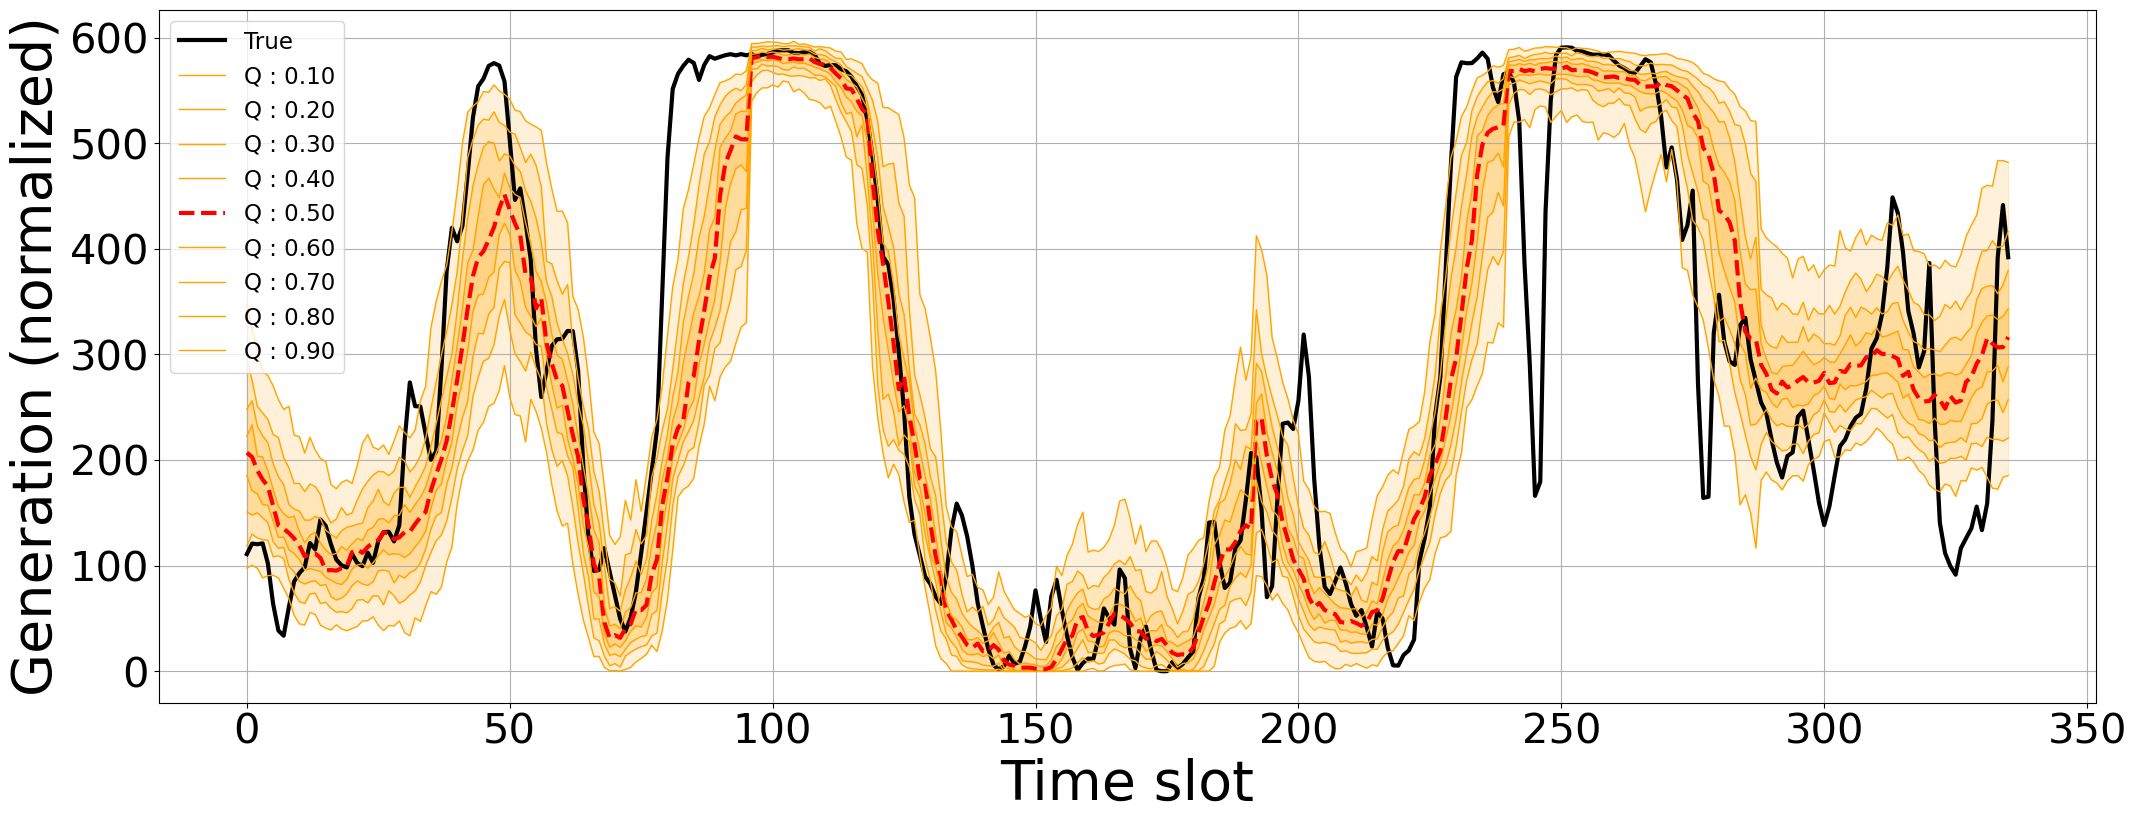

In [19]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(25,9))

## day 설정
start = 0 # None
end = 7 # None

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n_quantiles = len(quantiles)

test_y_normalized_inv = inv_test_output[start:end,:]
test_pred_ = inv_test_pred

ax.plot(test_y_normalized_inv.reshape(-1), label='True', color = 'black', linewidth = 3)

# # 0.5 pred
# ax.plot(test_pred[start:end,24*4:24*(4+1)].reshape(-1), label = 'pred', color = 'red', linewidth =3)

# # 0.1, 0.9
# ax.fill_between(np.arange((end - start)*24), test_pred[start:end,24*0:24*1].reshape(-1), test_pred[start:end,24*8:24*9].reshape(-1), color = 'orange', alpha = 0.7, label='90%')
# # 0.2, 0.8
# ax.fill_between(np.arange((end - start)*24), test_pred[start:end,24*1:24*2].reshape(-1), test_pred[start:end,24*7:24*8].reshape(-1), color = 'red', alpha = 0.3, label='80%')


# 0.1, 0.9
ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,0,:].reshape(-1), test_pred_[start:end,-1,:].reshape(-1), color = 'orange', alpha = 0.15)
# ax.fill_between(np.arange(48), test_pred_[start:end,0,:].reshape(-1), test_pred_[start:end,-1,:].reshape(-1), color = 'orange', alpha = 0.15)

# 0.2, 0.8
ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,1,:].reshape(-1), test_pred_[start:end,-2,:].reshape(-1), color = 'orange', alpha = 0.15)
# ax.fill_between(np.arange(48), test_pred_[start:end,1,:].reshape(-1), test_pred_[start:end,-2,:].reshape(-1), color = 'orange', alpha = 0.15)
# 0.3, 0.7
ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,2,:].reshape(-1), test_pred_[start:end,-3,:].reshape(-1), color = 'orange', alpha = 0.15)
# ax.fill_between(np.arange(48), test_pred_[start:end,2,:].reshape(-1), test_pred_[start:end,-3,:].reshape(-1), color = 'orange', alpha = 0.15)

# 0.4, 0.6
ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,3,:].reshape(-1), test_pred_[start:end,-4,:].reshape(-1), color = 'orange', alpha = 0.15)
# ax.fill_between(np.arange(48), test_pred_[start:end,3,:].reshape(-1), test_pred_[start:end,-4,:].reshape(-1), color = 'orange', alpha = 0.15)

# # 0.1, 0.9
# ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,48*0:48*1].reshape(-1), test_pred_[start:end,48*8:48*9].reshape(-1), color = 'orange', alpha = 0.15)
# # 0.2, 0.8
# ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,48*1:48*2].reshape(-1), test_pred_[start:end,48*7:48*8].reshape(-1), color = 'orange', alpha = 0.15)
# # 0.3, 0.7
# ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,48*2:48*3].reshape(-1), test_pred_[start:end,48*6:48*7].reshape(-1), color = 'orange', alpha = 0.15)
# # 0.4, 0.6
# ax.fill_between(np.arange((end - start)*48), test_pred_[start:end,48*3:48*4].reshape(-1), test_pred_[start:end,48*5:48*6].reshape(-1), color = 'orange', alpha = 0.15)


for q_idx in range(n_quantiles):
    if quantiles[q_idx] == 0.5:
      quantile_color = 'red'
      quantile_linestyle = '--'
      quantile_linewidth = 3
      alpha = 1
    else:
      quantile_color = 'orange'
      quantile_linestyle = 'solid'
      quantile_linewidth = 1
      alpha = 1

    # ax.plot(test_pred_[start:end,48*q_idx:48*(q_idx+1)].reshape(-1), label = ('Q : %.2f' %quantiles[q_idx]), color = quantile_color, linestyle = quantile_linestyle, linewidth = quantile_linewidth, alpha=alpha)
    ax.plot(test_pred_[start:end,q_idx,:].reshape(-1), label = ('Q : %.2f' %quantiles[q_idx]), color = quantile_color, linestyle = quantile_linestyle, linewidth = quantile_linewidth, alpha=alpha)
    

plt.grid()
# ax.set(title="Test set : PV power forecasting", ylabel="Normalized Power", xlabel="Time")

# plt.title("Test set : PV power forecasting", fontsize=20)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel('Time slot', fontsize=40)
plt.ylabel('Generation (normalized)', fontsize=40)

legend = ax.legend(loc='upper left',fontsize=20, frameon=1, prop={'size': 16.5})
plt.show()

In [390]:
import datetime

def ref_valid_diff_eda(df, columns, ref_datetime, step):
    
    #plt.figure(figsize=(15, 5))
    fig, axs = plt.subplots(2, figsize=(15, 5), gridspec_kw={'hspace': 0.2})
    fig.suptitle(f"Deviation of meteorological variables ({columns[1]}) predicted by the DWD model over time.")
    
    interval = 6
    
    start_datetime = pd.to_datetime(ref_datetime)
    ref_datetime = pd.to_datetime(ref_datetime)
    
    for idx in np.arange(step):
        label = f"RT : {ref_datetime}"
        axs[0].plot(df[df['ref_datetime'] == str(ref_datetime)][columns].set_index('valid_datetime'), label=label)
        ref_datetime = ref_datetime + datetime.timedelta(hours=6)
        axs[0].axvline(ref_datetime, color='lightgray', linestyle='--', linewidth=2)
    
    axs[0].set_xlabel('valid_datetime')
    axs[0].set_ylabel(f'{columns[1]}')
    axs[0].set_xlim([pd.to_datetime(start_datetime), pd.to_datetime(ref_datetime)])
    axs[0].legend(loc='upper right', fontsize=7)
    
    axs[1].plot(df[['valid_datetime', 'Wind_MWh_credit']].set_index('valid_datetime')[str(start_datetime):str(pd.to_datetime(ref_datetime).replace(tzinfo=None))], 
                'r--o',
                markersize=2,
                label='Wind_MWh_credit')
    axs[1].set_xlabel('valid_datetime')
    axs[1].set_ylabel('Wind_MWh_credit')
    axs[1].set_xlim([pd.to_datetime(start_datetime), pd.to_datetime(ref_datetime)])
    axs[1].set_ylim([-20, 600])
    axs[1].legend(loc='upper right', fontsize=7)
    
    for ax in axs:
        ax.label_outer()
        ax.grid(which='major', color='#CCCCCC', linestyle='--')
        ax.grid(which='minor', color='#CCCCCC', linestyle=':')
    return None

In [391]:
dwd_test_weather_copy = dwd_test_weather.copy().reset_index(drop=True)
dwd_test_weather_copy["Wind_MWh_credit"] = (0.5*wind_test["generation_mw"] - wind_test["boa"])

dwd_test_weather_copy.valid_datetime = pd.DatetimeIndex(dwd_test_weather_copy.valid_datetime)
dwd_test_weather_copy.ref_datetime = pd.DatetimeIndex(dwd_test_weather_copy.ref_datetime)

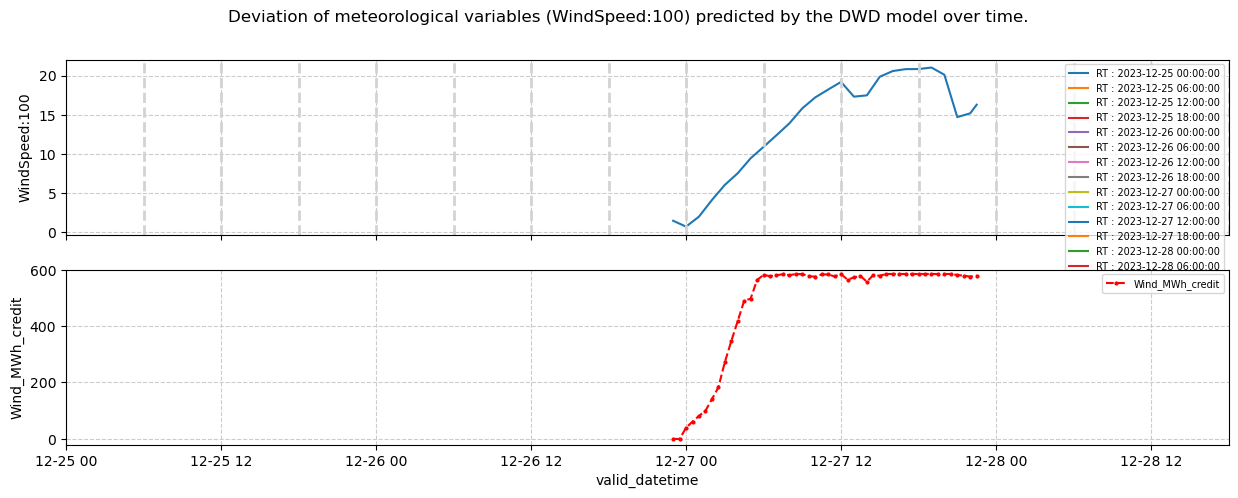

In [393]:
ref_valid_diff_eda(df = dwd_test_weather_copy, 
                   columns = ['valid_datetime','WindSpeed:100'], 
                   ref_datetime = '2023-12-25 00:00:00', 
                   step = 15)